In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
import warnings

In [4]:
tempelhof=pd.read_csv('TG_STAID002759.txt', skiprows=20, names=['SOUID', 'DATE', 'temp', 'Q_TG'], 
                 dtype={'SOUID':'int64', 'temp':'int64','Q_TG':'int64'})
tempelhof=tempelhof.set_index(pd.to_datetime(tempelhof.DATE, format='%Y%m%d', errors='ignore')).drop('DATE', axis=1)
tempelhof=tempelhof['2010':].drop('Q_TG', axis=1)
tempelhof['month_name']=tempelhof.index.month_name()
tempelhof['month']=tempelhof.index.month
tempelhof['year']=tempelhof.index.year

**Unit of temperature in raw data is 0.1 C, so must convert**

In [5]:
tempelhof['temp']=tempelhof['temp']/10

In [6]:
tempelhof.head()

,SOUID,temp,month_name,month,year
DATE,,,,,
2010-01-01,111448,-1.4,January,1,2010
2010-01-02,111448,-1.7,January,1,2010
2010-01-03,111448,-4.3,January,1,2010
2010-01-04,111448,-5.6,January,1,2010
2010-01-05,111448,-6.0,January,1,2010


### Stationarize Data

In [7]:
tempelhof['diff']=tempelhof['temp'].diff()

In [8]:
tempelhof['monthly_mean']=tempelhof.groupby('month')['diff'].transform('mean')
tempelhof['deseason']=tempelhof['diff']-tempelhof['monthly_mean']

In [9]:
tempelhof.fillna(method='bfill', inplace=True)

In [10]:
tempelhof.head()

,SOUID,temp,month_name,month,year,diff,monthly_mean,deseason
DATE,,,,,,,,
2010-01-01,111448,-1.4,January,1,2010,-0.3,-0.081471,-0.218529
2010-01-02,111448,-1.7,January,1,2010,-0.3,-0.081471,-0.218529
2010-01-03,111448,-4.3,January,1,2010,-2.6,-0.081471,-2.518529
2010-01-04,111448,-5.6,January,1,2010,-1.3,-0.081471,-1.218529
2010-01-05,111448,-6.0,January,1,2010,-0.4,-0.081471,-0.318529


### Estimate ARIMA Hyperparameters

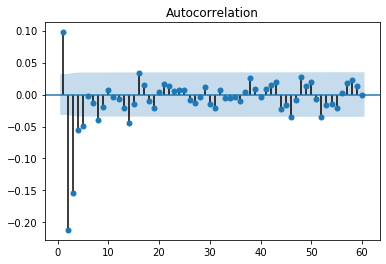

In [11]:
# calculate autregression model(maximum lag(p))
plot_acf(tempelhof['deseason'], lags=list(range(1, 61)))
None

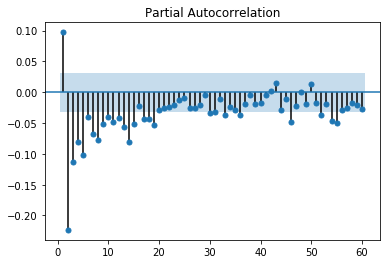

In [12]:
# calculate moving average(q)
plot_pacf(tempelhof['deseason'], lags=list(range(1,61))) 
None

**based on this, optimal parameters are p=4 and q=14**

### Grid Search ARIMA Hyperparameterization

In [13]:
p=[0,2,4,6,8]
d=range(0,3)
q=range(0,3)
pdq=list(itertools.product(p,d,q))
ytrain=tempelhof['deseason'][:'2019-04-30']
ytest=tempelhof['deseason']['2019-04-30':]

In [15]:
warnings.filterwarnings("ignore")
aic_list=[]
for param in pdq:
    try: 
        m=ARIMA(ytrain, order=param)
        result=m.fit(disp=0)
        aic_list.append(result.aic)
    except:
        aic_list.append(0)
        continue 
aic_table=pd.DataFrame({'pdq':pdq, 'aic_score':aic_list})

In [16]:
aic_table[aic_table.aic_score != 0].sort_values('aic_score').head()

,pdq,aic_score
19,"(4, 0, 1)",14753.309716
28,"(6, 0, 1)",14754.043022
29,"(6, 0, 2)",14754.455206
20,"(4, 0, 2)",14755.224003
37,"(8, 0, 1)",14755.959518


**with parameters (4,0,1) giving the lowest AIC score, this will be used for the modeling**

### ARIMA modeling

In [17]:
# method 1
model=ARIMA(ytrain, order=(4,0,1))
model_fit=model.fit()
ypred=model_fit.forecast(steps=30)[0]

In [18]:
ypred

array([8.44599846e-01, 5.34339916e-01, 3.28804689e-01, 2.54336132e-01,
       2.22429471e-01, 1.87963548e-01, 1.51092573e-01, 1.19722524e-01,
       9.57025373e-02, 7.71655436e-02, 6.22743161e-02, 5.01192614e-02,
       4.02535984e-02, 3.23072625e-02, 2.59186404e-02, 2.07742528e-02,
       1.66262288e-02, 1.32811796e-02, 1.05846625e-02, 8.41140644e-03,
       6.65984173e-03, 5.24803651e-03, 4.11005115e-03, 3.19278753e-03,
       2.45344560e-03, 1.85751604e-03, 1.37717930e-03, 9.90012790e-04,
       6.77944329e-04, 4.26407448e-04])

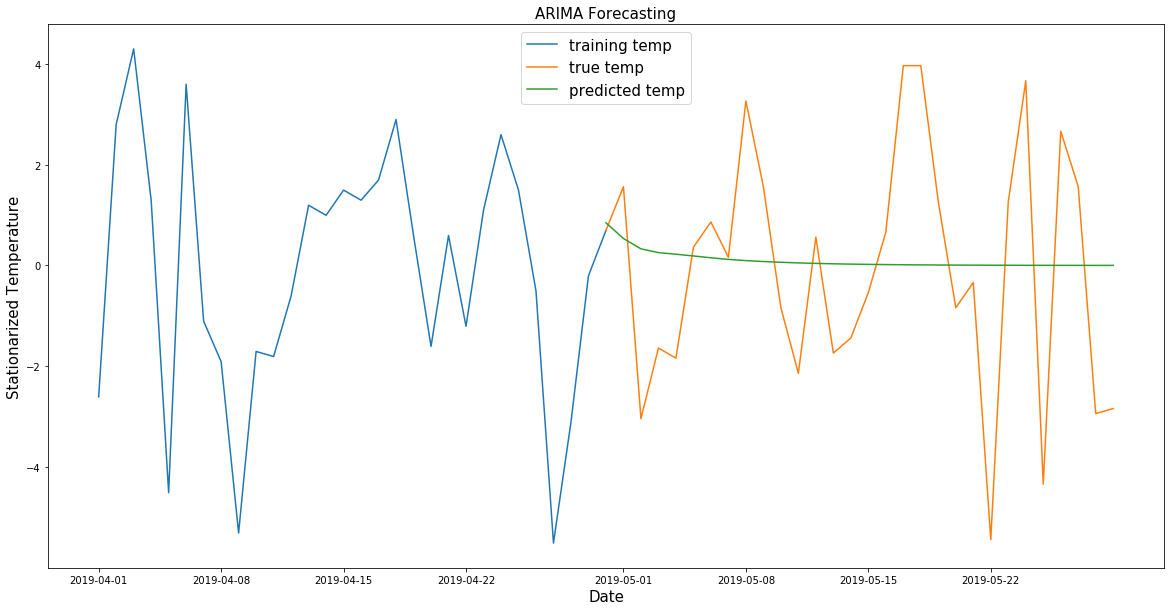

In [19]:
plt.figure(figsize=(20,10))
plt.plot(ytrain[-30:].index, ytrain[-30:], label='training temp')
plt.plot(ytest[:30].index, ytest[:30], label='true temp')
plt.plot(ytest[:30].index, ypred, label='predicted temp')
plt.title('ARIMA Forecasting', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Stationarized Temperature', fontsize=15)
plt.legend(fontsize=15)
plt.savefig('ARIMA_forecast.png')

In [20]:
# method 2: Rolling Forecast (https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
X=tempelhof['deseason']['2018-04-29':].values
size=int(len(X)*0.75)
train, test=X[0:size], X[size:len(X)]
history=[x for x in train]
predictions=list()
for t in range(len(test[:20])):
    model=ARIMA(history, order=(4,0,1))
    model_fit=model.fit(disp=0)
    output=model_fit.forecast()
    ypred=output[0]
    obs=test[t]
    print('predicted=%f, expected=%f' % (ypred, obs))

predicted=0.691664, expected=-2.038065
predicted=0.691664, expected=-0.838065
predicted=0.691664, expected=1.102333
predicted=0.691664, expected=8.502333
predicted=0.691664, expected=-0.197667
predicted=0.691664, expected=-0.297667
predicted=0.691664, expected=-0.697667
predicted=0.691664, expected=-1.097667
predicted=0.691664, expected=0.302333
predicted=0.691664, expected=-0.797667
predicted=0.691664, expected=-0.197667
predicted=0.691664, expected=-1.297667
predicted=0.691664, expected=-2.297667
predicted=0.691664, expected=1.702333
predicted=0.691664, expected=0.802333
predicted=0.691664, expected=0.602333
predicted=0.691664, expected=2.002333
predicted=0.691664, expected=-0.697667
predicted=0.691664, expected=-1.797667
predicted=0.691664, expected=4.002333
